# IDAO: expected time of orders in airports

Airports are special points for taxi service. Every day a lot of people use a taxi to get to the city centre from the airport.

One of important task is to predict how long a driver need to wait an order. It helps to understand what to do. Maybe the driver have to wait near doors, or can drink a tea, or even should drive to city center without an order.

We request you to solve a simple version of this prediction task.

**Task:** predict time of $k$ orders in airport (time since now when you get an order if you are $k$-th in queue), $k$ is one of 5 values (different for every airports).

**Data**
- train: number of order for every minutes for 6 months
- test: every test sample has datetime info + numer of order for every minutes for last 2 weeks

**Submission:** for every airport you should prepare a model which will be evaluated in submission system (code + model files). You can make different models for different airports.

**Evaluation:** for every airport for every $k$ sMAPE will be calculated and averaged. General leaderboard will be calculated via Borda count. 

## Baseline

In [2]:
%pylab inline

import catboost
import pandas as pd
import pickle
import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from numba import jit
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


Let's prepare a model for set2.

# Load train dataset

In [3]:
set_name = 'set1'
path_train_set = 'data/train/{}.csv'.format(set_name)

data = pd.read_csv(path_train_set)
data.datetime = data.datetime.apply(
    lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data = data.sort_values('datetime')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,0
1,2018-03-01 00:01:00,0
2,2018-03-01 00:02:00,0
3,2018-03-01 00:03:00,0
4,2018-03-01 00:04:00,1


In [4]:
@jit()
def exponential_smoothing_numba(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [5]:
data.num_orders = exponential_smoothing_numba(data.num_orders, 0.3)

In [6]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(32, 12))
        for alpha in alphas:
            plt.plot(exponential_smoothing_numba(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual", alpha=0.2)
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

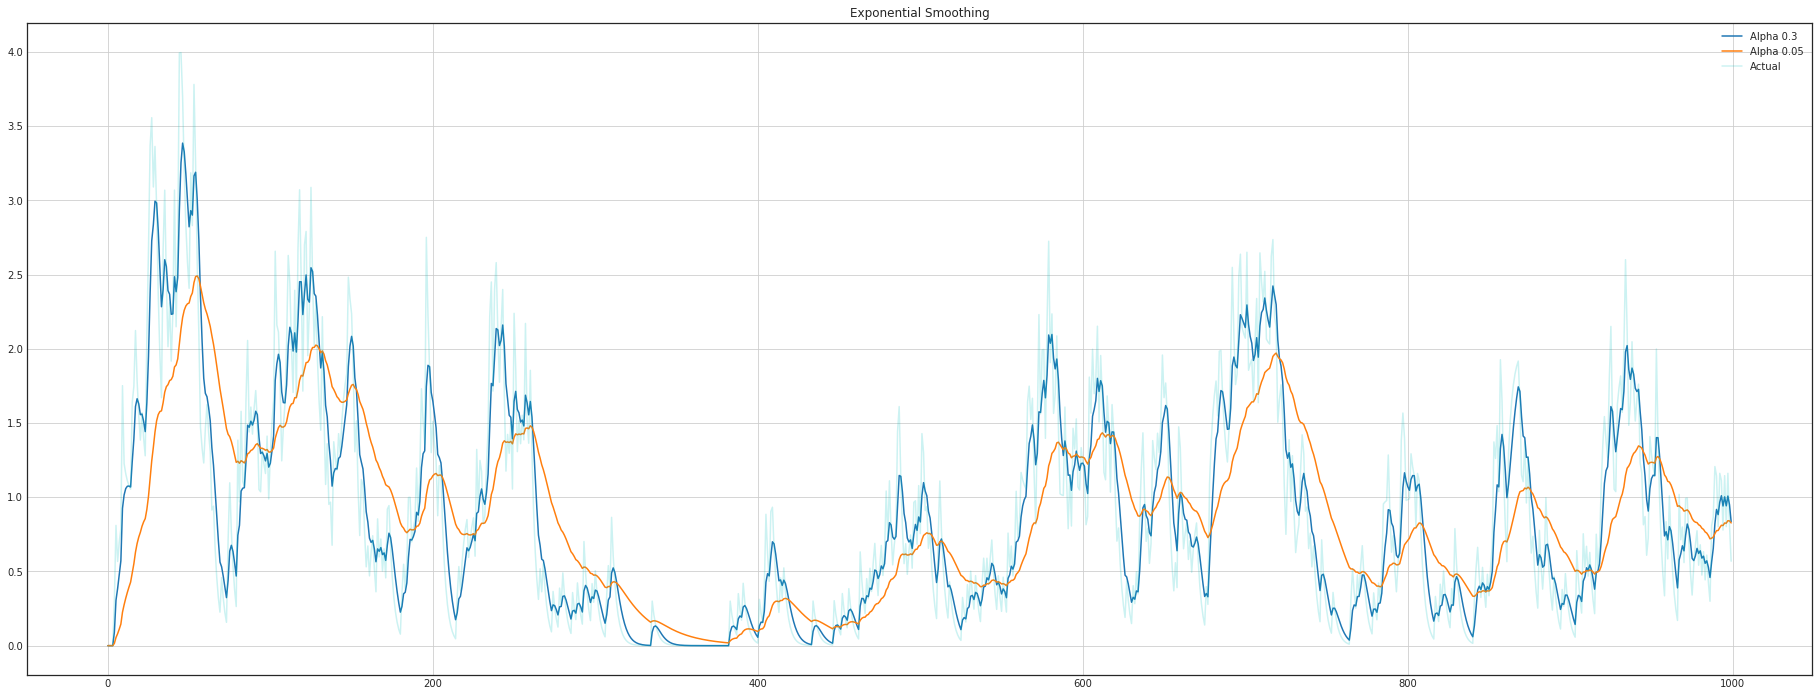

In [7]:
plotExponentialSmoothing(data.num_orders[:1000], [0.3,  0.05])

Predict position for set2.

In [8]:
target_positions = {
    'set1': [10, 30, 45, 60, 75],
    'set2': [5, 10, 15, 20, 25],
    'set3': [5, 7, 9, 11, 13]
}[set_name]

Some useful constant.

In [9]:
HOUR_IN_MINUTES = 60
DAY_IN_MINUTES = 24 * HOUR_IN_MINUTES
WEEK_IN_MINUTES = 7 * DAY_IN_MINUTES

MAX_TIME = DAY_IN_MINUTES

In [10]:
WEEK_IN_MINUTES

10080

## Generate train samples with targets

We have only history of orders (count of orders in every minutes) but we need to predict time of k orders since current minutes. So we should calculate target for train set. Also we will make a lot of samples from all set (we can only use two weeks of history while prediction so we can use only two weeks in every train sample).

In [11]:
samples = {
    'datetime': [],
    'history': []}

for position in target_positions:
    samples['target_{}'.format(position)] = []
    
num_orders = data.num_orders.values

In [12]:
samples

{'datetime': [],
 'history': [],
 'target_10': [],
 'target_30': [],
 'target_45': [],
 'target_60': [],
 'target_75': []}

To calculate target (minutes before k orders) we are going to use cumulative sum of orders. 

In [13]:
target_positions

[10, 30, 45, 60, 75]

In [14]:
# start after 2 weeks because of history
# finish earlier because of target calculation
for i in range(2 * WEEK_IN_MINUTES,
               len(num_orders) - 2 * DAY_IN_MINUTES):
    
    samples['datetime'].append(data.datetime[i])
    samples['history'].append(num_orders[i-2*WEEK_IN_MINUTES:i])
    
    # cumsum not for all array because of time economy
    cumsum_num_orders = num_orders[i+1:i+1+2*DAY_IN_MINUTES].cumsum()
    for position in target_positions:
        orders_by_positions = np.where(cumsum_num_orders >= position)[0]
        if len(orders_by_positions):
            time = orders_by_positions[0] + 1
        else:
            # if no orders in last days
            time = MAX_TIME
        samples['target_{}'.format(position)].append(time)

Convert to pandas.dataframe. Now we have targets to train and predict.

In [15]:
df = pd.DataFrame.from_dict(samples)
df.head()

,datetime,history,target_10,target_30,target_45,target_60,target_75
0,2018-03-15 00:00:00,"[0.0, 0.0, 0.0, 0.0, 0.3, 0.8099999999999999, ...",5,17,27,33,41
1,2018-03-15 00:01:00,"[0.0, 0.0, 0.0, 0.3, 0.8099999999999999, 0.567...",5,17,27,33,42
2,2018-03-15 00:02:00,"[0.0, 0.0, 0.3, 0.8099999999999999, 0.567, 0.6...",6,19,27,33,42
3,2018-03-15 00:03:00,"[0.0, 0.3, 0.8099999999999999, 0.567, 0.696899...",6,19,27,33,42
4,2018-03-15 00:04:00,"[0.3, 0.8099999999999999, 0.567, 0.69689999999...",7,20,27,34,42


# Train model

Let's generate simple features.

By time:

In [16]:
df['weekday'] = df.datetime.apply(lambda x: x.weekday())
df['hour'] = df.datetime.apply(lambda x: x.hour)
df['minute'] = df.datetime.apply(lambda x: x.minute)

In [17]:
df.head()

,datetime,history,target_10,target_30,target_45,target_60,target_75,weekday,hour,minute
0,2018-03-15 00:00:00,"[0.0, 0.0, 0.0, 0.0, 0.3, 0.8099999999999999, ...",5,17,27,33,41,3,0,0
1,2018-03-15 00:01:00,"[0.0, 0.0, 0.0, 0.3, 0.8099999999999999, 0.567...",5,17,27,33,42,3,0,1
2,2018-03-15 00:02:00,"[0.0, 0.0, 0.3, 0.8099999999999999, 0.567, 0.6...",6,19,27,33,42,3,0,2
3,2018-03-15 00:03:00,"[0.0, 0.3, 0.8099999999999999, 0.567, 0.696899...",6,19,27,33,42,3,0,3
4,2018-03-15 00:04:00,"[0.3, 0.8099999999999999, 0.567, 0.69689999999...",7,20,27,34,42,3,0,4


In [18]:
df.loc[0].history

array([0.        , 0.        , 0.        , ..., 2.68019656, 2.17613759,
       1.52329631])

Aggregators by order history with different shift and window size:

In [19]:
SHIFTS = [3, 5, 7, 10, 15, 20,
    HOUR_IN_MINUTES // 2,
    HOUR_IN_MINUTES,
    HOUR_IN_MINUTES*2,
    DAY_IN_MINUTES,
    DAY_IN_MINUTES * 2,
    WEEK_IN_MINUTES,
    WEEK_IN_MINUTES * 2]
WINDOWS = [3, 5, 7, 10, 15, 20,
    HOUR_IN_MINUTES // 2,
    HOUR_IN_MINUTES,
    HOUR_IN_MINUTES*2,
    DAY_IN_MINUTES,
    DAY_IN_MINUTES * 2,
    WEEK_IN_MINUTES,
    WEEK_IN_MINUTES * 2]

In [20]:
SHIFTS

[3, 5, 7, 10, 15, 20, 30, 60, 120, 1440, 2880, 10080, 20160]

In [21]:
WINDOWS

[3, 5, 7, 10, 15, 20, 30, 60, 120, 1440, 2880, 10080, 20160]

In [22]:
for shift in SHIFTS:
    for window in WINDOWS:
        if window > shift:
            continue
        if window == shift:
            df['num_orders_{}_{}'.format(shift, window)] = \
                df.history.apply(lambda x: x[-shift:].sum())
        else:
            df['num_orders_{}_{}'.format(shift, window)] = \
                df.history.apply(lambda x: x[-shift : -shift + window].sum())

In [23]:
df.head()

,datetime,history,target_10,target_30,target_45,target_60,target_75,weekday,hour,minute,...,num_orders_20160_10,num_orders_20160_15,num_orders_20160_20,num_orders_20160_30,num_orders_20160_60,num_orders_20160_120,num_orders_20160_1440,num_orders_20160_2880,num_orders_20160_10080,num_orders_20160_20160
0,2018-03-15 00:00:00,"[0.0, 0.0, 0.0, 0.0, 0.3, 0.8099999999999999, ...",5,17,27,33,41,3,0,0,...,4.913211,10.540033,19.383143,43.153500,121.128673,203.283830,1361.746449,2865.163586,9106.335975,18977.445642
1,2018-03-15 00:01:00,"[0.0, 0.0, 0.0, 0.3, 0.8099999999999999, 0.567...",5,17,27,33,42,3,0,1,...,6.139248,12.178023,20.768200,46.107450,122.590071,204.998681,1362.422514,2867.214510,9107.735183,18979.711949
2,2018-03-15 00:02:00,"[0.0, 0.0, 0.3, 0.8099999999999999, 0.567, 0.6...",6,19,27,33,42,3,0,2,...,7.297473,13.924616,22.337740,48.475215,124.213050,207.699077,1362.895760,2868.650157,9108.714628,18981.898365
3,2018-03-15 00:03:00,"[0.0, 0.3, 0.8099999999999999, 0.567, 0.696899...",6,19,27,33,42,3,0,3,...,8.408231,16.047231,23.736418,50.432650,125.649135,210.489354,1363.527032,2869.955110,9110.600239,18984.628855
4,2018-03-15 00:04:00,"[0.3, 0.8099999999999999, 0.567, 0.69689999999...",7,20,27,34,42,3,0,4,...,9.485762,17.833062,25.015493,52.102855,126.954394,212.442548,1365.168922,2870.868577,9112.220168,18987.140199


In [24]:
df = pd.concat([
    df.drop("weekday", axis=1), 
    pd.get_dummies(df['weekday'], prefix='weekday')
], axis=1)

# encode hour with sin/cos transformation
# credits - https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
df['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
df['cos_hour'] = np.cos(2*np.pi*df['hour']/24)
df['min_from_day'] = df['hour']*60+df['minute']
df['sin_min'] = np.sin(2*np.pi*df['minute']/24*60)
df['cos_min'] = np.cos(2*np.pi*df['minute']/24*60)
df.drop(["hour", "minute"], axis=1, inplace=True)

Train/validation split for time. Let's use last 4 weeks for validation.

In [25]:
df.datetime.min(), df.datetime.max()

(Timestamp('2018-03-15 00:00:00'), Timestamp('2018-08-29 23:59:00'))

In [52]:
df_train = df
target_cols = ['target_{}'.format(position) for position in target_positions]
y_train = df_train[target_cols]
df_train = df_train.drop(['datetime', 'history'] + target_cols, axis=1)

In [54]:
df_train.head()

,num_orders_3_3,num_orders_5_3,num_orders_5_5,num_orders_7_3,num_orders_7_5,num_orders_7_7,num_orders_10_3,num_orders_10_5,num_orders_10_7,num_orders_10_10,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,sin_hour,cos_hour,min_from_day,sin_min,cos_min
0,6.379630,7.570674,11.270108,4.429948,9.653282,13.352716,3.652909,5.735517,10.625995,17.005625,...,0,1,0,0,0,0.0,1.0,0,0.000000e+00,1.0
1,5.965741,7.399472,11.189076,6.100963,10.957298,14.746901,2.857036,6.414862,11.638196,17.603938,...,0,1,0,0,0,0.0,1.0,1,2.388680e-15,-1.0
2,5.976019,6.379630,10.832353,7.570674,11.270108,15.722831,2.899925,7.790403,12.646737,18.622756,...,0,1,0,0,0,0.0,1.0,2,-4.777360e-15,1.0
3,7.183213,5.965741,10.882647,7.399472,11.189076,16.105982,4.429948,9.653282,13.352716,20.535929,...,0,1,0,0,0,0.0,1.0,3,5.389684e-15,-1.0
4,7.428249,5.976019,11.217853,6.379630,10.832353,16.074187,6.100963,10.957298,14.746901,22.175151,...,0,1,0,0,0,0.0,1.0,4,-9.554721e-15,1.0


Also we will save models for prediction stage.

In [58]:
model_to_save = {
    'models': {}
}

In [105]:
iterations = {}

iterations['10'] = 300
iterations['30'] = 350
iterations['45'] = 350
iterations['60'] = 450
iterations['75'] = 450

What is good or bad model? We can compare our model with constant solution. For instance median (optimal solution for MAE).

In [ ]:
for position in target_positions:
    model = catboost.CatBoostRegressor(
        iterations=iterations['{}'.format(position)], learning_rate=1, loss_function='MAE', l2_leaf_reg=3.5, depth=6)
    model.fit(
        X=df_train,
        y=y_train['target_{}'.format(position)],
        verbose=500)

    print('target_{}'.format(position))
    
    model_to_save['models'][position] = model

0:	learn: 11.5355831	total: 49.7ms	remaining: 14.9s
299:	learn: 3.0745558	total: 14.2s	remaining: 0us
target_10
0:	learn: 29.5639231	total: 49.4ms	remaining: 17.3s
349:	learn: 6.3547882	total: 18.1s	remaining: 0us
target_30
0:	learn: 41.9975127	total: 49.9ms	remaining: 17.4s
349:	learn: 8.3432044	total: 19.2s	remaining: 0us
target_45
0:	learn: 54.0670522	total: 55.8ms	remaining: 25.1s
449:	learn: 9.4674869	total: 24.8s	remaining: 0us
target_60
0:	learn: 65.9115876	total: 57.4ms	remaining: 25.8s


Our model is better than constant solution. Saving model.

In [ ]:
pickle.dump(model_to_save, open('models.pkl', 'wb'))